In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
columns_names = ['session','client','?','choice'] + ["option_0"+str(i) for i in range(1,4)] + ["option_1"+str(i) for i in range(1,4)]

data = pd.read_csv("data_for_matlab.csv",header=None,index_col=None, names=columns_names )
data

,session,client,?,choice,option_01,option_02,option_03,option_11,option_12,option_13
0,5,0,1,0,105,105,80,32,144,80
1,5,0,2,1,21,95,80,6,130,80
2,5,0,3,1,125,85,80,52,124,80
3,5,0,4,0,41,75,80,26,110,80
4,5,0,5,1,145,65,80,72,104,80
...,...,...,...,...,...,...,...,...,...,...
1411,6,23,34,1,21,95,150,6,130,150
1412,6,23,35,0,125,85,150,52,124,150
1413,6,23,36,0,41,75,150,26,110,150
1414,6,23,37,1,145,65,150,72,104,150


In [3]:
#u=@(a,d,o) a*mean(d(:,5+o*3:7+o*3),2)-(1-a)*std(d(:,5+o*3:7+o*3),1,2);
def u(a,d,o):
    columns = ["option_" +str(int(o)) +str(i) for i in range(1,4)]
    return a*d[columns].mean(axis=1)-(1-a)*d[columns].std(axis=1,ddof=0)

def data_pred(a,d):
    return 1*(u(a,d,1) > u(a,d,0)) #+ .5*(u(a,data,0) == u(a,data,1))

def data_sc(a,d):
    predictions = data_pred(a,d)
    return 1*(d['choice']==predictions) #+ .5*(.5==predictions)

def data_res(a,d):
    d1 = d.copy()
    predictions = data_sc(a,d)
    d1['pred'] = predictions.copy()
    return d1[['session','client','pred']].groupby(by=['session','client']).mean()

data_res(.75,data).mean()

pred    0.718108
dtype: float64

0.75
pred    0.718108
dtype: float64


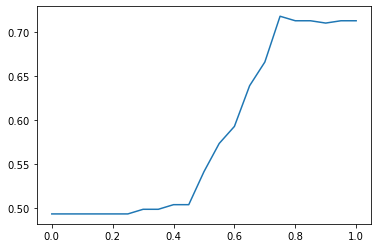

In [4]:
#find max with 1
A = np.linspace(0,1,21)
fit = []

for a in A:
    likelihood = data_res(a,data).mean()
    fit.append( likelihood )
fit = np.array(fit)

plt.plot(A,fit)

a_result = A[fit.argmax()]
print(a_result)
print(data_res(a_result,data).mean())

In [5]:
def e_step(a_results):
    #assign the groups
    likelihood_e = []
    for a_result in a_results:
        likelihood_e.append(data_res(a_result,data))
    likelihood_e =  np.array(likelihood_e)
    group = likelihood_e.argmax(axis=0)
    return group

def m_step(groups):
    #given the groups find a
    likelihood_m = []
    percent_type = []
    a_results = []
    
    N = groups.max() #number of groups...
    for  i in range(N+1):
        percent_type.append( (i==groups).mean() )
        A = np.linspace(1,0,21)
        likelihood_mi = []
        
        #figure out the best a
        for a in A:
            likelihood_mia = data_res(a,data)
            likelihood_mia = (likelihood_mia[ (i==groups) ]).mean()
            likelihood_mi.append(likelihood_mia)
            
        #compute summary stats using a
        likelihood_mi = np.array(likelihood_mi)
        likelihood_mi.shape
        likelihood_m.append(likelihood_mi.max())
        a_result = A[likelihood_mi.argmax()]
        a_results.append(a_result)
        
    return a_results, np.array(likelihood_m), percent_type

a_results= np.array([.05,.95])
groups =  e_step(a_results)
a_results, likelihood_m, percent_type = m_step(groups)

print(a_results, percent_type, likelihood_m)

[0.25, 1.0] [0.25, 0.75] [0.66666667 0.79883041]


In [6]:
a_results= np.array([.05,.5,.95])
for i in range(3):
    groups =  e_step(a_results)
    a_results, likelihood_m, percent_type = m_step(groups)

print(a_results, percent_type, likelihood_m)

[0.25, 0.7, 1.0] [0.18333333333333332, 0.38333333333333336, 0.43333333333333335] [0.66507177 0.7788493  0.85526316]
